In [ ]:
!pip install shap

In [ ]:
from __future__ import print_function

import shap
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Configs
np.random.seed(1)
shap.initjs()
sns.set_style("whitegrid")

plot_shap=True # NOTE: Turn False to disable shap plots as they can be slow to load 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Problem 3

### Part (A)

In [ ]:
# Mark the categories of interest
categories = ['alt.atheism', 'soc.religion.christian']

# Fetch the data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Set outcome class names
class_names = ['atheism', 'christian']

In [ ]:
# Split training data into corpus & labels
corpus_train = newsgroups_train['data']
y_train = newsgroups_train['target']

# Split test data into corpus & labels
corpus_test = newsgroups_test['data']
y_test = newsgroups_test['target']

# Check length
print("Training corpus length: {}, training labels length: {}".format(len(corpus_train), len(y_train)))
print("Test corpus length: {}, test labels length: {}".format(len(corpus_test), len(y_test)))

Training corpus length: 1079, training labels length: 1079
Test corpus length: 717, test labels length: 717


In [ ]:
# Initialize & apply tf-idf vectorizer
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

In [ ]:
# Train & fit SGD classifier 
model = SGDClassifier(loss='log')
model.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### Part (B)

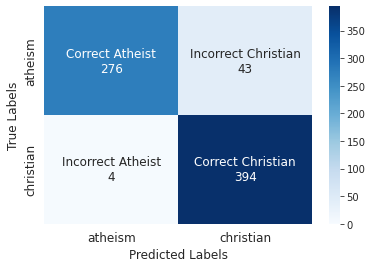

In [ ]:
# Get test set predictions
predictions = model.predict(X_test)

# Generate confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)

# Create confusion matrix labels
cm_labels = np.array([['Correct Atheist', 'Incorrect Christian'],
                      ['Incorrect Atheist', 'Correct Christian']])

# Zip together labels and counts
zipped_cm = zip(cm_labels.flatten(), confusion_matrix.flatten())
formatted_cm = np.asarray(["{}\n{}".format(label, count) for label, count in zipped_cm]).reshape(2, 2)

# Create confusion matrix heatmap
sns.heatmap(confusion_matrix, vmin=0, cmap='Blues', annot=formatted_cm, fmt='', xticklabels=class_names, yticklabels=class_names, annot_kws={"fontsize":12})
plt.xticks(fontsize=12)
plt.yticks(plt.yticks()[0], class_names, va='center', fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.xlabel("Predicted Labels", fontsize=12);


#### Explainer

In [ ]:
# Initialize explainer and apply to test data
explainer = shap.LinearExplainer(model, X_train, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_test)

# Convert X_test to dense format
X_test_array = X_test.toarray()

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


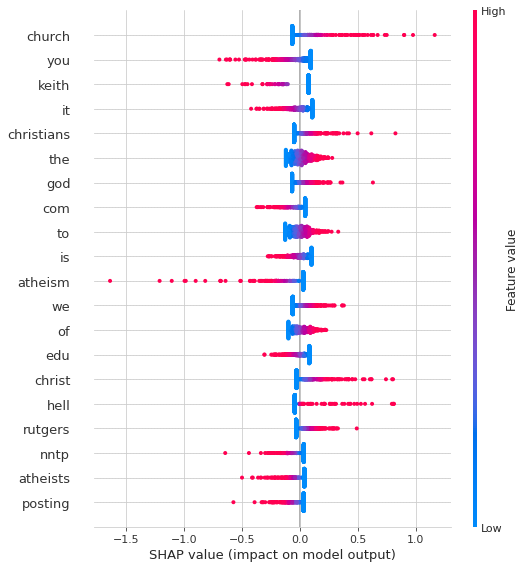

In [ ]:
# Display summary plot
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())

In [ ]:
# Select 5 documents in the test set for explanation
cc_idx = np.random.choice(np.where((y_test == predictions) & (y_test == 1))[0], 2, replace=False)
ca_idx = np.random.choice(np.where((y_test == predictions) & (y_test == 0))[0])
ic_idx = np.random.choice(np.where((y_test != predictions) & (y_test == 1))[0])

# Below command returns a document that appears mis-labeled --> run subequent command to retreive 2 documents, then only add 1 to list. See footnote 1 on report page 6 for further explanation
# ia_idx = np.random.choice(np.where((y_test != predictions) & (y_test == 0))[0])
ia_idx = np.random.choice(np.where((y_test != predictions) & (y_test == 0))[0], 2, replace=False)[0]

# Concatenate indices into single list
sample_indices = np.concatenate([cc_idx, ca_idx, ic_idx, ia_idx], axis=None)

In [ ]:
# Print document 1 w/ SHAP visual explainer
idx = sample_indices[0]

shap.initjs()
print("Label: {}".format("Christian" if y_test[idx] else "Atheist"))
print("Prediction: {}\n".format("Christian" if predictions[idx] else "Atheist"))
print(corpus_test[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names()
)

Label: Christian
Prediction: Christian

From: dike@scic.intel.com (Charles Dike)
Subject: Re: Mormon Temples
Organization: Intel Corporation, Beaverton, OR
Lines: 44


	From: dhammers@pacific.? (David Hammerslag)

	How do you (Mormons) reconcile the idea of eternal marriage with 
	Christ's statement that in the resurrection people will neither 
	marry nor be given in marriage (Luke, chapt. 20)?

Footnotes in some bibles reference this verse to the Book of Tobit.
Tobit is in the Septuagint. Goodspeed published it in a book called 
"The Apocrypha". Most any bookstore will have this. At any rate, the Jews 
of Christ's day had this book. It is a story mostly centered around the
son of Tobit who was named Tobias. There was a young lady, Sarah, who had 
entered the bridal chamber with seven brothers in succession. The brothers 
all died in the chamber before consumating the marriage.

Tobias was entitled to have Sarah for his wife (3:17) because Tobias was
her only relative and "...she was d

In [ ]:
## Print highest weight words for document 1

# Get features and weights
feats = vectorizer.get_feature_names()
vals = shap_values[idx]

# Initialize dicts to store positive & negative weights
pos_weights = defaultdict(float)
neg_weights = defaultdict(float)

# Store positive (Christian) and negative (atheist) values in dictionaries
for feat_i, val_i in zip(feats, vals):
  if val_i > 0:
    pos_weights[feat_i] += val_i
  elif val_i < 0:
    neg_weights[feat_i] += val_i

# Print top 5 positive (Christian) and top 5 negative (atheist) features
print("Top 5 Christian features:")
for word, weight in list(sorted(pos_weights.items(), key=lambda x: x[1], reverse=True))[:5]:
  print(word, weight)
    
print("\nTop 5 atheist features:")
for word, weight in list(sorted(neg_weights.items(), key=lambda x: x[1]))[:5]:
  print(word, weight)

Top 5 Christian features:
her 0.2666145456254068
marriage 0.19786372485659567
christ 0.17688491898023567
heaven 0.12750662126768358
marry 0.08874305742486345

Top 5 atheist features:
therefore -0.07672674677292575
god -0.06626018132929067
church -0.06546734131720976
we -0.06058502328473949
christians -0.04885890745415936


In [ ]:
# Print document 2 w/ SHAP visual explainer
idx = sample_indices[1]

shap.initjs()
print("Label: {}".format("Christian" if y_test[idx] else "Atheist"))
print("Prediction: {}\n".format("Christian" if predictions[idx] else "Atheist"))
print(corpus_test[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names()
)

Label: Christian
Prediction: Christian

From: aidler@sol.uvic.ca (E Alan  Idler)
Subject: Re: Mormon beliefs about bastards
Organization: University of Victoria
Lines: 75

erh0362@tesla.njit.edu writes:

>    Could anyone enlighten me on how the Mormon church views 
>children born out of wedlock?  In particular I'm interested to know if any 
>stigma is attached to the children as opposed to the parents.  

All children are born pure, i.e., without sin.
However, most saints would view a pregnancy
outside of marriage as an occasion of mourning.
(Some church members would be much more
judgmental, but that is *their* problem.)

In situations where welfare assistance is 
provided through our Church, bishops usually
require that the family be making some effort to
live the Gospel standards and provide for 
themselves.

However, there are occasions when assistance is
provided because of the children in the home.
As a former bishop of mine said, "Children are 
always worthy before God."

>I'm 

In [ ]:
## Print highest weight words for document 2

# Get features and values
feats = vectorizer.get_feature_names()
vals = shap_values[idx]

# Initialize dicts to store weights
pos_weights = defaultdict(float)
neg_weights = defaultdict(float)

# Store positive (Christian) and negative (atheist) values in dictionaries
for feat_i, val_i in zip(feats, vals):
  if val_i > 0:
    pos_weights[feat_i] += val_i
  elif val_i < 0:
    neg_weights[feat_i] += val_i

# Print top 5 positive (Christian) and top 5 negative (atheist) features
print("Top 5 Christian features:")
for word, weight in list(sorted(pos_weights.items(), key=lambda x: x[1], reverse=True))[:5]:
  print(word, weight)
    
print("\nTop 5 atheist features:")
for word, weight in list(sorted(neg_weights.items(), key=lambda x: x[1]))[:5]:
  print(word, weight)

Top 5 Christian features:
church 0.6343638093457707
temple 0.16299219039074195
sin 0.14547762213883939
parents 0.12696768675432843
may 0.10759054342165407

Top 5 atheist features:
or -0.17374089154441147
christians -0.04885890745415936
their -0.0460373620822483
posting -0.044413775019861816
and -0.044375750588686744


In [ ]:
# Print document 3 w/ SHAP visual explainer
idx = sample_indices[2]

shap.initjs()
print("Label: {}".format("Christian" if y_test[idx] else "Atheist"))
print("Prediction: {}\n".format("Christian" if predictions[idx] else "Atheist"))
print(corpus_test[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names()
)

Label: Atheist
Prediction: Atheist

From: sandvik@newton.apple.com (Kent Sandvik)
Subject: Re: islamic authority over women
Organization: Cookamunga Tourist Bureau
Lines: 16

In article <C5rB1G.43u@darkside.osrhe.uoknor.edu>, bil@okcforum.osrhe.edu
(Bill Conner) wrote:
> To credit religion with the awesome power to dominate history is to
> misunderstand human nature, the function of religion and of course,
> history. I believe that those who distort history in this way know
> exaclty what they're doing, and do it only for affect.

However, to underestimate the power of religion creating historical
events is also a big misunderstanding. For instance, would the
30-year-old war have ever started if there were no fractions
between the Protestants and the Vatican?

Cheers,
Kent
---
sandvik@newton.apple.com. ALink: KSAND -- Private activities on the net.



In [ ]:
## Print highest weight words for document 3

# Get pre-selection features and values
feats = vectorizer.get_feature_names()
vals = shap_values[idx]

# Initialize dicts to store positive & negative weights
pos_weights = defaultdict(float)
neg_weights = defaultdict(float)

# Store positive (Christian) and negative (atheist) values in dictionaries
for feat_i, val_i in zip(feats, vals):
  if val_i > 0:
    pos_weights[feat_i] += val_i
  elif val_i < 0:
    neg_weights[feat_i] += val_i

# Print top 5 positive (Christian) and top 5 negative (atheist) features
print("Top 5 Christian features:")
for word, weight in list(sorted(pos_weights.items(), key=lambda x: x[1], reverse=True))[:5]:
  print(word, weight)
    
print("\nTop 5 atheist features:")
for word, weight in list(sorted(neg_weights.items(), key=lambda x: x[1]))[:5]:
  print(word, weight)

Top 5 Christian features:
authority 0.13242327852622995
you 0.09475598120252554
keith 0.0762069496069971
it 0.04671710852482525
16 0.041370820502433715

Top 5 atheist features:
sandvik -0.6774997684995324
osrhe -0.35844227203648454
kent -0.2689543777485378
apple -0.25357304555196264
newton -0.24899105372746003


In [ ]:
# Print document 4 w/ SHAP visual explainer
idx = sample_indices[3]

shap.initjs()
print("Label: {}".format("Christian" if y_test[idx] else "Atheist"))
print("Prediction: {}\n".format("Christian" if predictions[idx] else "Atheist"))
print(corpus_test[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names()
)

Label: Christian
Prediction: Atheist

From: sandvik@newton.apple.com (Kent Sandvik)
Subject: Re: SOC.RELIGION.CHRISTIAN
Organization: Cookamunga Tourist Bureau
Lines: 23

In article <May.16.01.56.14.1993.6674@geneva.rutgers.edu>,
sfp@lemur.cit.cornell.edu (Sheila Patterson) wrote:
> As for the atheists/agnostics who read this list: if you aren't
> christian and if you have no intention of ever becoming one why on
> earth do you waste your time and mine by participating on a christian
> discussion list ?

I don't think we should draw borders around newsgroups, christians
are free to read and post entries on the atheist newsgroups, and 
muslims are free to so so in other groups as well.

It's up to each individual to define their time schedule concerning 
postings. The problems we all have noticed on various newsgroups
is the evangelistical method of telling that 'I am right, and you are
wrong'. This is true of both theists and atheists.

Hopefully a more constructive dialogue between th

In [ ]:
## Print highest weight words for document 4

# Get features and values
feats = vectorizer.get_feature_names()
vals = shap_values[idx]

# Initialize dicts to store positive & negative weights
pos_weights = defaultdict(float)
neg_weights = defaultdict(float)

# Store positive (Christian) and negative (atheist) values in dictionaries
for feat_i, val_i in zip(feats, vals):
  if val_i > 0:
    pos_weights[feat_i] += val_i
  elif val_i < 0:
    neg_weights[feat_i] += val_i

# Print top 5 positive (Christian) and top 5 negative (atheist) features
print("Top 5 Christian features:")
for word, weight in list(sorted(pos_weights.items(), key=lambda x: x[1], reverse=True))[:5]:
  print(word, weight)
    
print("\nTop 5 atheist features:")
for word, weight in list(sorted(neg_weights.items(), key=lambda x: x[1]))[:5]:
  print(word, weight)

Top 5 Christian features:
christian 0.3004842903216684
rutgers 0.15710455111327218
christians 0.1322273523987807
geneva 0.12307280996017354
1993 0.09255084616758609

Top 5 atheist features:
sandvik -0.5712627329196682
kent -0.2267803178790969
atheists -0.21471303655544652
apple -0.21372552739265038
newton -0.209947392513382


In [ ]:
# Print document 5 w/ SHAP visual explainer
idx = sample_indices[4]

shap.initjs()
print("Label: {}".format("Christian" if y_test[idx] else "Atheist"))
print("Prediction: {}\n".format("Christian" if predictions[idx] else "Atheist"))
print(corpus_test[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names()
)

Label: Atheist
Prediction: Christian

From: acooper@mac.cc.macalstr.edu (Turin Turambar, ME Department of Utter Misery)
Subject: From soc.religion.christian
Organization: Macalester College
Lines: 41



I found this little gem, I don't know if anyone has any interest/comments...


--------------------------------------------------------------------------------

Hi everyone,
           I'm a commited Christian that is battling with a problem.  I know
that romans talks about how we are saved by our faith not our deeds, yet
hebrews and james say that faith without deeds is useless, saying' You fools,
do you still think that just believing is enough?'

Now if someone is fully believing but there life is totally lead by themselves
and not by God, according to Romans that person is still saved by there faith.
But then there is the bit which says that God preferes someone who is cold to
him (i.e. doesn't know him - condemned) so a lukewarm Christian someone who
knows and believes in God but d

In [ ]:
## Print highest weight words for document 5

# Get features and values
feats = vectorizer.get_feature_names()
vals = shap_values[idx]

# Initialize dicts to store positive & negative weights
pos_weights = defaultdict(float)
neg_weights = defaultdict(float)

# Store positive (Christian) and negative (atheist) values in dictionaries
for feat_i, val_i in zip(feats, vals):
  if val_i > 0:
    pos_weights[feat_i] += val_i
  elif val_i < 0:
    neg_weights[feat_i] += val_i

# Print top 5 positive (Christian) and top 5 negative (atheist) features
print("Top 5 Christian features:")
for word, weight in list(sorted(pos_weights.items(), key=lambda x: x[1], reverse=True))[:5]:
  print(word, weight)
    
print("\nTop 5 atheist features:")
for word, weight in list(sorted(neg_weights.items(), key=lambda x: x[1]))[:5]:
  print(word, weight)

Top 5 Christian features:
christian 0.3673287667150708
faith 0.28855531508378085
romans 0.2534431693441983
saved 0.1711309593018302
christ 0.14472647523614046

Top 5 atheist features:
macalstr -0.19237315972832814
acooper -0.17091134116412457
is -0.11498776324656404
you -0.08134810331940935
believing -0.08052881014883702


### Part (C)


#### Part (i)

In [ ]:
# Compute accuracy of classifier and number of misclassified documents
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
num_misclassified = sum(y_test != predictions)

print("Model accuracy: {:.5f}".format(accuracy))
print("Number of misclassified documents: {}".format(num_misclassified))

Model accuracy: 0.93445
Number of misclassified documents: 47


#### Part (ii)

In [ ]:
# Get probability predictions from model
prob_preds = model.predict_proba(X_test)

# Isolate misclassified probability predictions
misclassified_prob_preds = prob_preds[np.where(y_test != predictions)]

# Calculate confidence values
conf_values = np.array([abs(prob[0] - prob[1]) for prob in misclassified_prob_preds])

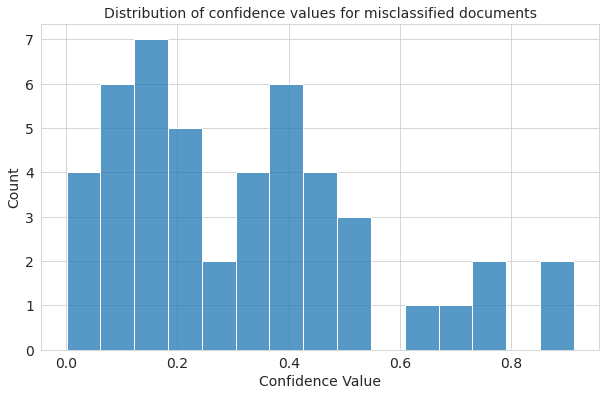

In [ ]:
# Plot distribution of confidence values
plt.figure(figsize=(10, 6))

sns.histplot(conf_values, bins=15)
plt.title("Distribution of confidence values for misclassified documents", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Confidence Value", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

#### Part (iii)

In [ ]:
## Identify tokens (word_j) that contributed to the misclassification of documents

# Get indicdes of misclassified documents
misclassified_indices = np.where(y_test != predictions)[0]

# Initialize dict to count each word's contributions to misclassified documents
word_contributions = {word: {'count': 0, 'weight': 0} for word in vectorizer.get_feature_names()}

# For each misclassified document, get words that contributed to misclassification
for idx in misclassified_indices:
  
  # For incorrect atheist classifications, incremement counts for atheist words
  if predictions[idx] == 0:
    for feat_i, val_i in zip(vectorizer.get_feature_names(), shap_values[idx, :]):
      if val_i < 0:
        word_contributions[feat_i]['count'] += 1
        word_contributions[feat_i]['weight'] += abs(val_i)
  
  # For incorrect Christian classifications, incrememnt counts for Christian words
  else:
    for feat_i, val_i in zip(vectorizer.get_feature_names(), shap_values[idx, :]):
      if val_i > 0:
        word_contributions[feat_i]['count'] += 1
        word_contributions[feat_i]['weight'] += abs(val_i)

# Filter out words that did not contribute to any misclassifications
word_contributions = {key: val for (key, val) in word_contributions.items() if val['count'] > 0}

In [ ]:
# Get highest cumulative weight words
list(sorted(word_contributions.items(),key=lambda x: x[1]['weight'], reverse=True))[:60]

[('keith', {'count': 43, 'weight': 3.2768988331008737}),
 ('the', {'count': 29, 'weight': 2.4927172536872524}),
 ('of', {'count': 30, 'weight': 2.399344441072474}),
 ('christian', {'count': 23, 'weight': 2.265762815938069}),
 ('church', {'count': 13, 'weight': 2.2199675011302653}),
 ('umd', {'count': 44, 'weight': 2.1304311040621955}),
 ('you', {'count': 27, 'weight': 2.0139522315985405}),
 ('it', {'count': 26, 'weight': 2.0095365590731205}),
 ('faith', {'count': 14, 'weight': 1.911257666043249}),
 ('mangoe', {'count': 44, 'weight': 1.911031540399907}),
 ('christ', {'count': 16, 'weight': 1.899133687442587}),
 ('islam', {'count': 43, 'weight': 1.7752040833287275}),
 ('jesus', {'count': 18, 'weight': 1.7559392715832973}),
 ('atheists', {'count': 35, 'weight': 1.6688777201287366}),
 ('to', {'count': 23, 'weight': 1.660575528077962}),
 ('edu', {'count': 28, 'weight': 1.5411790643658274}),
 ('com', {'count': 33, 'weight': 1.4985085698195337}),
 ('is', {'count': 25, 'weight': 1.467874468086

In [ ]:
# Get highest count words
list(sorted(word_contributions.items(),key=lambda x: x[1]['count'], reverse=True))[:50]

[('alink', {'count': 44, 'weight': 0.07329671257003875}),
 ('alternatives', {'count': 44, 'weight': 0.003025993174871747}),
 ('applies', {'count': 44, 'weight': 0.12051911203086381}),
 ('apply', {'count': 44, 'weight': 0.08640080372495512}),
 ('aren', {'count': 44, 'weight': 0.05619910240243836}),
 ('borders', {'count': 44, 'weight': 0.006531913047476912}),
 ('bureau', {'count': 44, 'weight': 0.07180398683707256}),
 ('charley', {'count': 44, 'weight': 0.5886627155941446}),
 ('cheers', {'count': 44, 'weight': 0.11395782638190473}),
 ('closed', {'count': 44, 'weight': 0.06214574367757086}),
 ('cookamunga', {'count': 44, 'weight': 0.07180398683707256}),
 ('dave', {'count': 44, 'weight': 0.172731879978498}),
 ('draw', {'count': 44, 'weight': 0.022433493930102702}),
 ('fairly', {'count': 44, 'weight': 0.01934047687622116}),
 ('ksand', {'count': 44, 'weight': 0.07329671257003875}),
 ('lous', {'count': 44, 'weight': 0.1857266290713833}),
 ('mangoe', {'count': 44, 'weight': 1.911031540399907})

In [ ]:
# Retreive counts to plot
count_list = []
for word, vals in word_contributions.items():
  count_list.append(vals['count'])

In [ ]:
# Retreive weights to plot
weight_list = []
for word, vals in word_contributions.items():
  weight_list.append(vals['weight'])

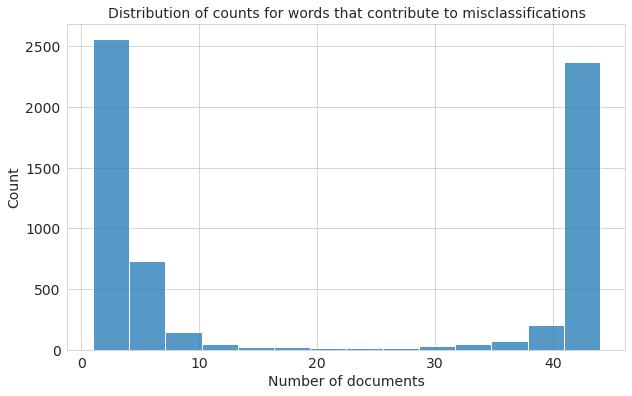

In [ ]:
# Plot the distribution of counts
plt.figure(figsize=(10, 6))

sns.histplot(count_list)
plt.title("Distribution of counts for words that contribute to misclassifications", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Number of documents", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

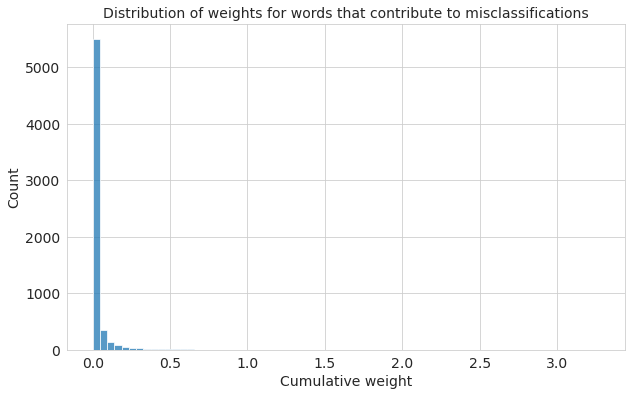

In [ ]:
# Plot the distribution of weights
plt.figure(figsize=(10, 6))

sns.histplot(weight_list, bins=70)
plt.title("Distribution of weights for words that contribute to misclassifications", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Cumulative weight", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

### Part (D)

In [ ]:
## Implement a strategy for feature selection

# Fetch the data, remove headers & footers from training set
newsgroups_train_head_foot_rmvd = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers'))

# Do not alter test set
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

In [ ]:
# Split training data into corpus & labels
new_corpus_train = newsgroups_train_head_foot_rmvd['data']
new_y_train = newsgroups_train_head_foot_rmvd['target']

# Split test data into corpus & labels
new_corpus_test = newsgroups_test['data']
new_y_test = newsgroups_test['target']

# Check length
print("Training corpus length: {}, training labels length: {}".format(len(new_corpus_train), len(new_y_train)))
print("Test corpus length: {}, test labels length: {}".format(len(new_corpus_test), len(new_y_test)))

Training corpus length: 1079, training labels length: 1079
Test corpus length: 717, test labels length: 717


In [ ]:
# Define features to remove
remove_words = [
       'keith','the','of','umd','you','it','mangoe','to','edu','com','is','and','caltech','wingate','host','nntp','islam','islamic',
       'as','an','with','our','sandvik','or','jaeger','so','this','objective','001125','0195','024150','062328','065230','071',
       '081052','0908','091139','1000','10193','109','111651','11292','113255','114127','114140','115561','11825','11836',
       'charley','cheers','dave','ksand','lous','marv','princeton','ucsb','au','cobb','more','temple'
]

In [ ]:
# Initialize & fit tf-idf vectorizer, remove stop words
new_vectorizer = TfidfVectorizer(stop_words=remove_words)

new_X_train = new_vectorizer.fit_transform(new_corpus_train)
new_X_test = new_vectorizer.transform(new_corpus_test)

In [ ]:
# Re-train model and get predictions
new_model = SGDClassifier(loss='log')
new_model.fit(new_X_train, new_y_train)
new_predictions = new_model.predict(new_X_test)

In [ ]:
# Generate confusion matrix & compute accuracy for new_model
new_accuracy = sklearn.metrics.accuracy_score(new_y_test, new_predictions)
new_confusion_matrix = sklearn.metrics.confusion_matrix(new_y_test, new_predictions)

print("Accuracy: {:.5f}\n".format(new_accuracy))
print(new_confusion_matrix)

Accuracy: 0.93305

[[275  44]
 [  4 394]]


In [ ]:
# Identify documents that were misclassified before feature selection but correctly classified after feature selection
altered_pred_indices = np.where((new_y_test != predictions) & (new_y_test == new_predictions))[0]

# Print indices
print("Indices of documents that were misclassified before feature selection\nbut correctly classified after feature selection:\n\n{}".format(altered_pred_indices))

# Extract some index
altered_idx = altered_pred_indices[6]

Indices of documents that were misclassified before feature selection
but correctly classified after feature selection:

[ 54  62 107 216 271 366 413 447 473 568 605 615 685 703]


In [ ]:
# Initialize new explainer and apply to test data
new_explainer = shap.LinearExplainer(new_model, new_X_train, feature_perturbation='interventional')
new_shap_values = new_explainer.shap_values(new_X_test)

# Convert new_X_test to dense format
new_X_test_array = new_X_test.toarray()

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [ ]:
# Print SHAP visual explainer from before feature selection
shap.initjs()
print("Label: {}".format("Christian" if y_test[altered_idx] else "Atheist"))
print("Prediction: {}\n".format("Christian" if predictions[altered_idx] else "Atheist"))
print(corpus_test[altered_idx])
shap.force_plot(
    explainer.expected_value, shap_values[altered_idx,:], X_test_array[altered_idx,:],
    feature_names=vectorizer.get_feature_names()
)

Label: Atheist
Prediction: Christian

From: mathew <mathew@mantis.co.uk>
Subject: Discordian & SubGenius books, addresses etc.
Distribution: world
Organization: Mantis Consultants, Cambridge. UK.
Lines: 204

As requested, here are some addresses of sources of bizarre religious satire
and commentary...  Plus some bijou book reviewettes.

---

Loompanics Unlimited
PO Box 1197
Port Townsend, WA 98368. USA.

Publishers of one of the most infamous mail-order book catalogue in the 
world.  Anarchism, Discordianism, Libertarianism, cryogenics, money-making
(legal and illegal), privacy and security, self-defense, and all kinds of
other stuff that keeps Christians awake at nights.

---

The Church of the SubGenius
PO Box 140306
Dallas, TX 75214. USA.

The original end times church for post-human mutants; a high temple for 
scoffers, mockers and blasphemers.  Be one of the few to board the X-ist 
saucers in 1998 and escape Space God JHVH-1's stark fist of removal.  J.R.
"Bob" Dobbs, God of Sales

In [ ]:
## Collect positive and negative contributions from before feature selection

# Get pre-selection features and values
pre_selection_feats = vectorizer.get_feature_names()
pre_selection_vals = shap_values[altered_idx]

# Initialize dicts to store values
pre_selection_pos_weights = defaultdict(float)
pre_selection_neg_weights = defaultdict(float)

# Store positive (Christian) and negative (atheist) values in dictionaries
for feat_i, val_i in zip(pre_selection_feats, pre_selection_vals):
  if val_i > 0:
    pre_selection_pos_weights[feat_i] += val_i
  elif val_i < 0:
    pre_selection_neg_weights[feat_i] += val_i

# Print top 10 positive (Christian) and top 10 negative (atheist) features
print("Top 10 Christian features:")
for word, weight in list(sorted(pre_selection_pos_weights.items(), key=lambda x: x[1], reverse=True))[:10]:
  print(word, weight)
    
print("\nTop 10 atheist features:")
for word, weight in list(sorted(pre_selection_neg_weights.items(), key=lambda x: x[1]))[:10]:
  print(word, weight)

Top 10 Christian features:
of 0.18863439799366918
church 0.15595946392772067
and 0.1339987762423812
mail 0.11566300660994841
the 0.11460677945433219
it 0.09425719927854813
christians 0.09400755586355332
edu 0.0822295840127711
his 0.07973305145613353
sin 0.07752867728354032

Top 10 atheist features:
mathew -0.20922238910944596
uk -0.13915893344604605
you -0.12344197862713155
po -0.09689629888975526
mantis -0.07770822103424872
or -0.06885658849502203
quote -0.05977318302307421
stuff -0.05658606708090406
robert -0.05270435068422446
political -0.0516313195742232


In [ ]:
# Print SHAP visual explainer from after feature selection
shap.initjs()
print("Label: {}".format("Christian" if new_y_test[altered_idx] else "Atheist"))
print("Prediction: {}\n".format("Christian" if new_predictions[altered_idx] else "Atheist"))
print(new_corpus_test[altered_idx])
shap.force_plot(
    new_explainer.expected_value, new_shap_values[altered_idx,:], new_X_test_array[altered_idx,:],
    feature_names=new_vectorizer.get_feature_names()
)

Label: Atheist
Prediction: Atheist

From: mathew <mathew@mantis.co.uk>
Subject: Discordian & SubGenius books, addresses etc.
Distribution: world
Organization: Mantis Consultants, Cambridge. UK.
Lines: 204

As requested, here are some addresses of sources of bizarre religious satire
and commentary...  Plus some bijou book reviewettes.

---

Loompanics Unlimited
PO Box 1197
Port Townsend, WA 98368. USA.

Publishers of one of the most infamous mail-order book catalogue in the 
world.  Anarchism, Discordianism, Libertarianism, cryogenics, money-making
(legal and illegal), privacy and security, self-defense, and all kinds of
other stuff that keeps Christians awake at nights.

---

The Church of the SubGenius
PO Box 140306
Dallas, TX 75214. USA.

The original end times church for post-human mutants; a high temple for 
scoffers, mockers and blasphemers.  Be one of the few to board the X-ist 
saucers in 1998 and escape Space God JHVH-1's stark fist of removal.  J.R.
"Bob" Dobbs, God of Sales, 

In [ ]:
## Collect positive and negative contributions from after feature selection

# Get post-selection features and values
post_selection_feats = new_vectorizer.get_feature_names()
post_selection_vals = new_shap_values[altered_idx]

# Initialize dicts to store values
post_selection_pos_weights = defaultdict(float)
post_selection_neg_weights = defaultdict(float)

# Store positive (Christian) and negative (atheist) values in dictionaries
for feat_i, val_i in zip(post_selection_feats, post_selection_vals):
  if val_i > 0:
    post_selection_pos_weights[feat_i] += val_i
  elif val_i < 0:
    post_selection_neg_weights[feat_i] += val_i

# Print top 10 positive (Christian) and top 10 negative (atheist) features
print("Top 10 Christian features:")
for word, weight in list(sorted(post_selection_pos_weights.items(), key=lambda x: x[1], reverse=True))[:10]:
  print(word, weight)
    
print("\nTop 10 atheist features:")
for word, weight in list(sorted(post_selection_neg_weights.items(), key=lambda x: x[1]))[:10]:
  print(word, weight)

Top 10 Christian features:
church 0.18016521772184269
mail 0.16113049003958502
christians 0.1438051033156257
his 0.13305139646004682
sin 0.10799797245731743
christian 0.08034426871170985
writes 0.07050705507796767
black 0.06737449979210651
send 0.040043385350532645
we 0.03813304725462278

Top 10 atheist features:
mathew -0.2685920029847892
uk -0.24364813519388073
po -0.21349009328459467
subgenius -0.10982164973132644
your -0.0873349720990329
list -0.07796997834994081
mantis -0.07683753897078682
robert -0.07258549236886579
stuff -0.07131357686376921
quote -0.06746653797664458
